In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import fashion_mnist, mnist

In [3]:
my_dataset = fashion_mnist
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 784)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, input_dim=X.shape[1], compile_model_flag=True, lr=0.001, activation='tanh', kernel_initializer=initializers.glorot_uniform(), 
              reduce = 1,  output_size = len(np.unique(y))):
    # Creo el modelo
    inp = Input(shape=(input_dim,))
    #bias_initializer = initializers.RandomUniform(-0.1, 0.1)
    bias_initializer = initializers.glorot_uniform()
    #bias_initializer = initializers.zeros()
    first_layer_out = Dense(784//reduce, activation=activation, name='hidden_1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(input_dim,))(inp)
    second_layer_out = Dense(784//reduce, activation=activation, name='hidden_2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(first_layer_out)
    output = Dense(output_size, name='Salida', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, activation='softmax')(second_layer_out)
    model = Model(inp, output)
    model_multiple_out = Model(inp, [first_layer_out, second_layer_out, output])
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model, model_multiple_out


model, model_multiple_out = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 784)               615440    
_________________________________________________________________
hidden_2 (Dense)             (None, 784)               615440    
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [6]:
initial_weights = 'mlp.fminist.initial.hdf5'
best_weights = 'mlp.fminist.best.hdf5'
model, model_multiple_out = get_model()
model.save_weights(initial_weights)
epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/5
1594/1594 [==============================] - 2s 1ms/step - loss: 0.5209 - accuracy: 0.8138 - val_loss: 0.4755 - val_accuracy: 0.8185
Epoch 2/5
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4091 - accuracy: 0.8515 - val_loss: 0.4186 - val_accuracy: 0.8469
Epoch 3/5
1594/1594 [==============================] - 2s 1ms/step - loss: 0.3736 - accuracy: 0.8633 - val_loss: 0.4590 - val_accuracy: 0.8420
Epoch 4/5
1594/1594 [==============================] - 2s 1ms/step - loss: 0.3521 - accuracy: 0.8710 - val_loss: 0.4097 - val_accuracy: 0.8515
Epoch 5/5
1594/1594 [==============================] - 2s 1ms/step - loss: 0.3422 - accuracy: 0.8750 - val_loss: 0.4070 - val_accuracy: 0.8508


In [7]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 741us/step - loss: 0.4070 - accuracy: 0.8508


[0.4069996476173401, 0.8507999777793884]

In [8]:
from LTH_helper import prune_and_initilize, plot_MC_boundaries_keras, prune_delta_weights, get_model_sparcity

In [9]:
pms = np.linspace(0.0001, 0.9999, 50)
accs = []
model.load_weights(best_weights)
for i, pm in enumerate(pms):
    pruned_model = prune_and_initilize(model, pm, initial_weights)
    acc = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
    accs.append(acc)
    print(i, pm, acc)

Instructions for updating:
Please use `layer.add_weight` method instead.
0 0.0001 0.10000000149011612
1 0.020504081632653062 0.10000000149011612
2 0.04090816326530613 0.10000000149011612
3 0.061312244897959195 0.10010000318288803
4 0.08171632653061225 0.13449999690055847
5 0.10212040816326531 0.20569999516010284
6 0.12252448979591839 0.23070000112056732
7 0.14292857142857143 0.26840001344680786
8 0.1633326530612245 0.3465000092983246
9 0.18373673469387755 0.34540000557899475
10 0.2041408163265306 0.30730000138282776
11 0.22454489795918367 0.3325999975204468
12 0.24494897959183676 0.37560001015663147
13 0.2653530612244898 0.3917999863624573
14 0.2857571428571429 0.4343999922275543
15 0.30616122448979594 0.5083000063896179
16 0.326565306122449 0.5080999732017517
17 0.34696938775510205 0.5741999745368958
18 0.3673734693877551 0.5598999857902527
19 0.3877775510204082 0.6151999831199646
20 0.40818163265306123 0.6474999785423279
21 0.4285857142857143 0.6615999937057495
22 0.44898979591836735

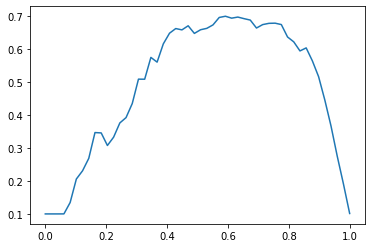

In [10]:
plt.plot(pms, accs)

In [11]:
model.load_weights(initial_weights)
model.evaluate(X_test, y_test, verbose=0)[1]

0.10109999775886536

In [12]:
best = np.argmax(accs)
print(pms[best], accs[best])
model.load_weights(best_weights)
pruned_model = prune_and_initilize(model, pms[best], initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)

0.5918183673469388 0.6988999843597412
313/313 [==============================] - 0s 820us/step - loss: 1.1522 - accuracy: 0.6989
0.6988999843597412


In [14]:
pruned_model = prune_and_initilize(model, 0.2, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)

313/313 [==============================] - 0s 825us/step - loss: 1.7584 - accuracy: 0.3117
0.3116999864578247


In [15]:
pruned_model = prune_and_initilize(model, 0.8, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)

313/313 [==============================] - 0s 803us/step - loss: 1.4652 - accuracy: 0.6247
0.6247000098228455


# Delta weights

In [57]:
model, _ = get_model()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['accuracy'])
model_delta_untrained, model_delta_trained, model_untrained = prune_delta_weights(model, X_train, y_train, epochs=1)

model_delta_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_delta_trained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])

1594/1594 [==============================] - 1s 937us/step - loss: 1.1189 - accuracy: 0.6596


In [58]:
print("Trained model")
model.evaluate(X_test, y_test)
print("Delta untrained model")
model_delta_untrained.evaluate(X_test, y_test)
print("Delta trained model")
model_delta_trained.evaluate(X_test, y_test)
print("untrained model")
model_untrained.evaluate(X_test, y_test)

Trained model
313/313 [==============================] - 0s 785us/step - loss: 0.8067 - accuracy: 0.7354
Delta untrained model
313/313 [==============================] - 0s 782us/step - loss: 1.2969 - accuracy: 0.5727
Delta trained model
313/313 [==============================] - 0s 805us/step - loss: 1.4514 - accuracy: 0.5580
untrained model
313/313 [==============================] - 0s 803us/step - loss: 2.4537 - accuracy: 0.0780


[2.4537034034729004, 0.07800000160932541]

In [44]:
get_model_sparcity(model_delta_untrained)

input_69: 

hidden_1: 
0.48884416649312784 614656
0.3826530612244898 784

hidden_2: 
0.4842139342982091 614656
0.42857142857142855 784

Salida: 
0.34030612244897956 7840
0.7 10

Network sparcity:
0.4855028940931438


In [45]:
model_untrained.save_weights('untrained.hdf5')
pruned_model_50 = prune_and_initilize(model, 1 - 0.4923, 'untrained.hdf5')

In [46]:
pruned_model_50.evaluate(X_test, y_test)

313/313 [==============================] - 0s 818us/step - loss: 1.0629 - accuracy: 0.7746


[1.062920093536377, 0.7746000289916992]

In [91]:
get_model_sparcity(pruned_model_48)

prune_low_magnitude_hidden_1: 
0.5197704081632653 1568
0.0 784

prune_low_magnitude_hidden_2: 
0.5199981778425656 614656
0.0 784

prune_low_magnitude_Salida: 
0.5199829931972789 7056
0.0 9

Network sparcity:
0.5186850751451932


In [82]:
get_model_sparcity(model_delta_untrained)

input_77: 

hidden_1: 
0.26658163265306123 1568
0.41836734693877553 784

hidden_2: 
0.48743199448146607 614656
0.41964285714285715 784

Salida: 
0.3901643990929705 7056
0.5555555555555556 9

Network sparcity:
0.4856087072722239


In [83]:
get_model_sparcity(model_delta_trained)

input_77: 

hidden_1: 
0.26658163265306123 1568
0.41836734693877553 784

hidden_2: 
0.48743199448146607 614656
0.41964285714285715 784

Salida: 
0.3901643990929705 7056
0.5555555555555556 9

Network sparcity:
0.4856087072722239
